IMPORTING ALL THE MODULES AND DEPENDENCIES

In [1]:
import pandas as pd
import requests
import re
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from config import MODEL_PATH, VECTORIZER_PATH, LABEL_MAP
from preprocess import preprocess_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhijat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhijat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


GET YOUR DailyDialog.csv using URL


In [2]:
DATASET_URL = "https://raw.githubusercontent.com/Abhijat-M/data/refs/heads/main/DailyDialog.csv" 

Function to load data from DATASET_URL and clean data from preprocess.py which is then called in model.py


In [3]:
# Function to load and clean the dataset from a remote URL
# Handles commas inside text by reading line-by-line and splitting on the last comma.
def load_data_from_url():   
    """
    Load and clean the dataset from a remote URL.
    Handles commas inside text by reading line-by-line and splitting on the last comma.
    """
    try:
        response = requests.get(DATASET_URL)
        response.raise_for_status()  # Raise exception for HTTP errors
        lines = response.text.strip().split('\n')

        texts = []
        emotions = []
        skipped_lines = []

        for i, line in enumerate(lines):
            line = line.strip()
            if not line or ',' not in line:
                continue

            # Try to parse quoted text
            if line.startswith('"') and '","' in line:
                parts = line.split('","', 1)
                if len(parts) == 2:
                    text = parts[0][1:]  # Remove opening quote
                    emotion = parts[1][:-1] if parts[1].endswith('"') else parts[1]
                else:
                    skipped_lines.append((i, line))
                    continue
            else:
                # Split on last comma
                parts = line.rsplit(',', 1)
                if len(parts) != 2:
                    skipped_lines.append((i, line))
                    continue
                text, emotion = parts

            # Clean and validate
            emotion = emotion.strip().lower()
            if emotion in LABEL_MAP:
                texts.append(text.strip())
                emotions.append(emotion)
            else:
                skipped_lines.append((i, line, f"Unknown emotion: {emotion}"))

        if not texts:
            raise ValueError("No valid data found. All lines were skipped.")

        # Show skipped lines for debugging
        if skipped_lines:
            print(f"\nSkipped {len(skipped_lines)} lines:")
            for item in skipped_lines[:5]:  # Show first 5 for brevity
                print(f"Line {item[0]}: {item[1]}")
                if len(item) > 2:
                    print(f"  Reason: {item[2]}")

        # Create DataFrame
        df = pd.DataFrame({"text": texts, "emotion": emotions})
        df["Cleaned_Text"] = df["text"].apply(preprocess_text)

        return df["Cleaned_Text"], df["emotion"]

    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.Series(), pd.Series()



Script to train and see model accuracy and classification report from train_model() in model.py


In [4]:
# Main script execution for training the model

X, y = load_data_from_url()
if X.empty or y.empty:
    raise ValueError("Data loading failed. Check dataset format.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))





Skipped 1 lines:
Line 0: text,sentiment
  Reason: Unknown emotion: sentiment
Model Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

       anger       0.66      0.69      0.68       452
        fear       0.68      0.63      0.65       434
         joy       0.71      0.61      0.66       465
     neutral       0.63      0.78      0.69       451
     sadness       0.73      0.66      0.69       464

    accuracy                           0.68      2266
   macro avg       0.68      0.68      0.67      2266
weighted avg       0.68      0.68      0.67      2266



Confusion matrix of the model

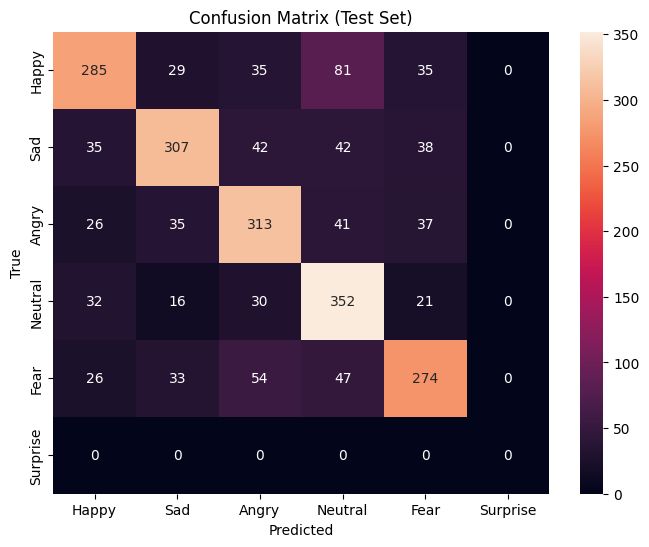

In [5]:
cm = confusion_matrix(y_test, y_pred, labels=list(LABEL_MAP.keys()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABEL_MAP.values(), yticklabels=LABEL_MAP.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.savefig("confusion_matrix.png")
plt.show()
plt.close()

Saving the model using joblib to load for application use. (Note: We can use ONNX for mobile deploying or cross platform deployment)

In [6]:
import joblib

# Save the model and vectorizer
joblib.dump(model, "emotion_classifier.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

Load saved models

In [7]:
model = joblib.load("emotion_classifier.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")

Demo Prediction using the trained model

In [8]:

text = "I feel amazing today!"
cleaned_text = preprocess_text(text)
X = vectorizer.transform([cleaned_text])
prediction = model.predict(X)
print(f"Predicted emotion: {prediction[0]}")

Predicted emotion: neutral
